<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Binaria_Base3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


## Funções

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao



---

*  [Keras, output of model predict_proba](https://stackoverflow.com/questions/41716380/keras-output-of-model-predict-proba/41729210#41729210)
*  [keras: what is the difference between model.predict and model.predict_proba](https://stackoverflow.com/questions/40747679/keras-what-is-the-difference-between-model-predict-and-model-predict-proba)



In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Segmentado/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
           
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado3/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado3/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado3/Validation'

In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [9]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 4230 images belonging to 2 classes.
Found 1100 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [11]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 0.00%, AUC: 40.35%, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [16]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 39s - loss: 0.7427 - acc: 0.5375 - val_loss: 0.7225 - val_acc: 0.4219

Epoch 00001: val_loss improved from inf to 0.72247, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 2/50
 - 41s - loss: 0.6866 - acc: 0.5312 - val_loss: 0.7252 - val_acc: 0.5000

Epoch 00002: val_loss did not improve from 0.72247
Epoch 3/50
 - 41s - loss: 0.6977 - acc: 0.5438 - val_loss: 0.7586 - val_acc: 0.3281

Epoch 00003: val_loss did not improve from 0.72247
Epoch 4/50
 - 40s - loss: 0.7262 - acc: 0.4813 - val_loss: 0.7048 - val_acc: 0.4688

Epoch 00004: val_loss improved from 0.72247 to 0.70476, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 5/50
 - 44s - loss: 0.6922 - acc: 0.6000 - val_loss: 0.7658 - val_acc: 0.4844

Epoch 00005: val_loss did not improve from 0.70476
Epoch 6/50
 - 45s - loss: 0.6971 - acc: 0.5812 - val_loss: 0.7357 - val_acc: 0.4844

Epoch 00006: val_loss did not improve from 0.70476
Epoch 7/50
 - 45s 

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

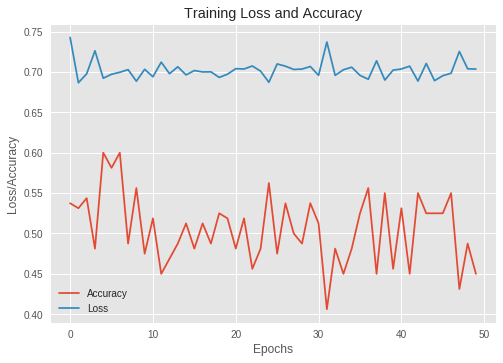

In [18]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [28]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [29]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 40.35%, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


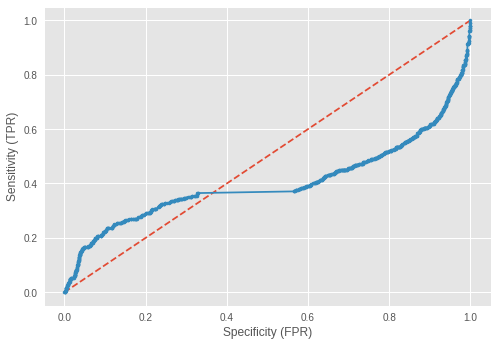

In [30]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa - Test Precision: 18.83%, AUC: 49.20%, Accuracy: 21.86%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [35]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6896 - acc: 0.5875 - val_loss: 0.6914 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 0.69137, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6883 - acc: 0.5250 - val_loss: 0.6884 - val_acc: 0.5625

Epoch 00002: val_loss improved from 0.69137 to 0.68843, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 3/50
 - 1s - loss: 0.6897 - acc: 0.4226 - val_loss: 0.6897 - val_acc: 0.7500

Epoch 00003: val_loss did not improve from 0.68843
Epoch 4/50
 - 1s - loss: 0.6867 - acc: 0.6875 - val_loss: 0.6884 - val_acc: 0.9531

Epoch 00004: val_loss improved from 0.68843 to 0.68837, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 5/50
 - 1s - loss: 0.6848 - acc: 0.7938 - val_loss: 0.6881 - val_acc: 0.8594

Epoch 00005: val_loss improved from 0.68837 to 0.68808, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

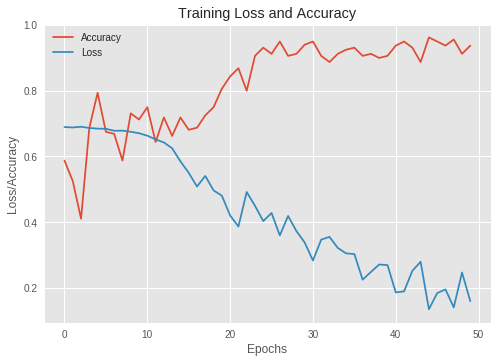

In [37]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [38]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [39]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 18.83%, AUC: 49.20%, Accuracy: 21.86%


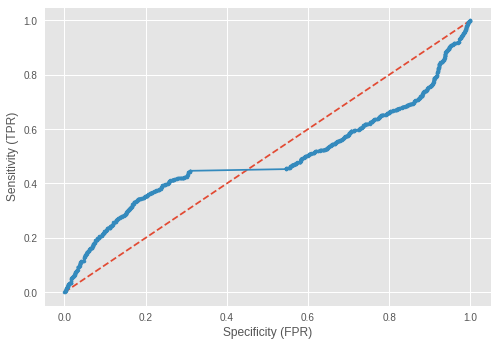

In [40]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 19.64%, AUC: 71.95%, Accuracy: 19.64%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [45]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 4.5449 - acc: 0.5094 - val_loss: 1.0164 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 1.01645, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 3.0317 - acc: 0.5719 - val_loss: 0.9080 - val_acc: 0.7109

Epoch 00002: val_loss improved from 1.01645 to 0.90802, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 3/50
 - 1s - loss: 2.4299 - acc: 0.6250 - val_loss: 0.5435 - val_acc: 0.8438

Epoch 00003: val_loss improved from 0.90802 to 0.54347, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 4/50
 - 1s - loss: 1.5622 - acc: 0.7094 - val_loss: 0.6192 - val_acc: 0.8516

Epoch 00004: val_loss did not improve from 0.54347
Epoch 5/50
 - 1s - loss: 0.9859 - acc: 0.7750 - val_loss: 0.8257 - val_acc: 0.8828

Epoch 00005: val_loss did not improve from 0.54347
Epoch 6/50
 - 1s - loss: 0.7395 - acc: 0.8758 - val_loss: 1.2208 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

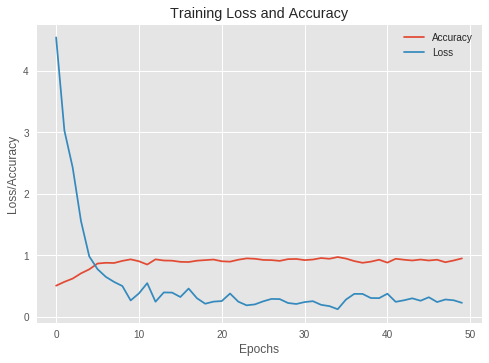

In [47]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [48]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [49]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 71.95%, Accuracy: 19.64%


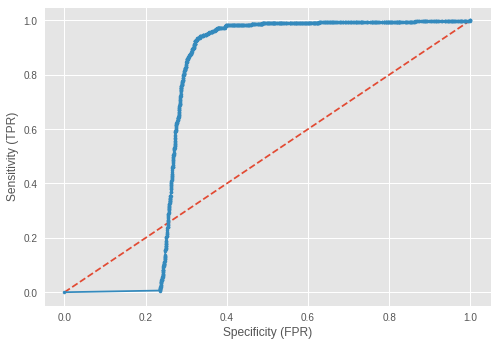

In [50]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 76.02%, AUC: 94.12%, Accuracy: 88.52%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [55]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5415 - acc: 0.7281 - val_loss: 1.7235 - val_acc: 0.5859

Epoch 00001: val_loss improved from inf to 1.72348, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.3054 - acc: 0.9094 - val_loss: 1.7933 - val_acc: 0.6406

Epoch 00002: val_loss did not improve from 1.72348
Epoch 3/50
 - 1s - loss: 0.3238 - acc: 0.8969 - val_loss: 0.5148 - val_acc: 0.8984

Epoch 00003: val_loss improved from 1.72348 to 0.51477, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 4/50
 - 1s - loss: 0.2692 - acc: 0.9469 - val_loss: 0.3353 - val_acc: 0.9297

Epoch 00004: val_loss improved from 0.51477 to 0.33529, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 5/50
 - 1s - loss: 0.2629 - acc: 0.9281 - val_loss: 0.5931 - val_acc: 0.8750

Epoch 00005: val_loss did not improve from 0.33529
Epoch 6/50
 - 1s - loss: 0.2417 - acc: 0.9375 - val_loss: 0.2407 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

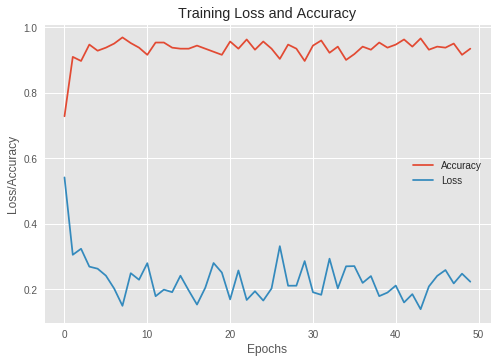

In [57]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [58]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [59]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 76.02%, AUC: 94.12%, Accuracy: 88.52%


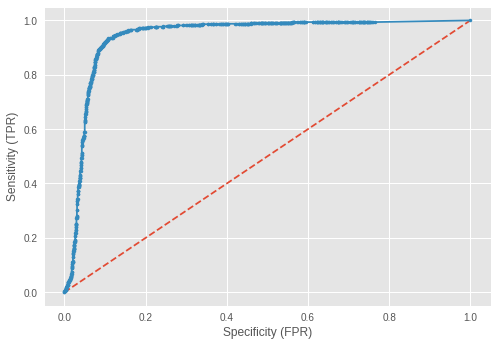

In [60]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 19.64%, AUC: 14.17%, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [65]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 6.6879 - acc: 0.4969 - val_loss: 9.0575 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 9.05747, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 8.4750 - acc: 0.4625 - val_loss: 6.5097 - val_acc: 0.3438

Epoch 00002: val_loss improved from 9.05747 to 6.50974, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 3/50
 - 0s - loss: 5.8219 - acc: 0.5625 - val_loss: 4.1466 - val_acc: 0.6719

Epoch 00003: val_loss improved from 6.50974 to 4.14657, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 4/50
 - 0s - loss: 6.2466 - acc: 0.5219 - val_loss: 5.7675 - val_acc: 0.4844

Epoch 00004: val_loss did not improve from 4.14657
Epoch 5/50
 - 0s - loss: 5.2936 - acc: 0.5750 - val_loss: 6.5478 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 4.14657
Epoch 6/50
 - 0s - loss: 3.2755 - acc: 0.6531 - val_loss: 2.0219 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

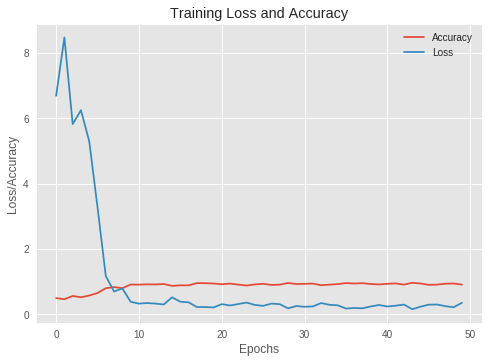

In [67]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [68]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [69]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 14.17%, Accuracy: 19.64%


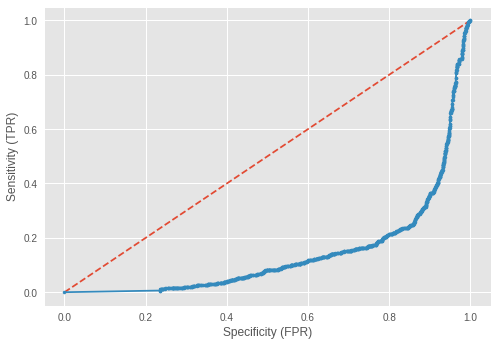

In [70]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 27.07%, AUC: 41.66%, Accuracy: 50.94%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [75]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.5128 - acc: 0.7781 - val_loss: 0.6749 - val_acc: 0.7578

Epoch 00001: val_loss improved from inf to 0.67485, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 2/50
 - 0s - loss: 0.3649 - acc: 0.8688 - val_loss: 0.3925 - val_acc: 0.8594

Epoch 00002: val_loss improved from 0.67485 to 0.39246, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 3/50
 - 0s - loss: 0.3429 - acc: 0.8844 - val_loss: 0.5821 - val_acc: 0.8125

Epoch 00003: val_loss did not improve from 0.39246
Epoch 4/50
 - 0s - loss: 0.2867 - acc: 0.9219 - val_loss: 0.6137 - val_acc: 0.8182

Epoch 00004: val_loss did not improve from 0.39246
Epoch 5/50
 - 0s - loss: 0.2558 - acc: 0.9344 - val_loss: 0.3407 - val_acc: 0.9219

Epoch 00005: val_loss improved from 0.39246 to 0.34070, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 6/50
 - 1s - loss: 0.2563 - acc: 0.9344 - val_loss: 0.4009 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

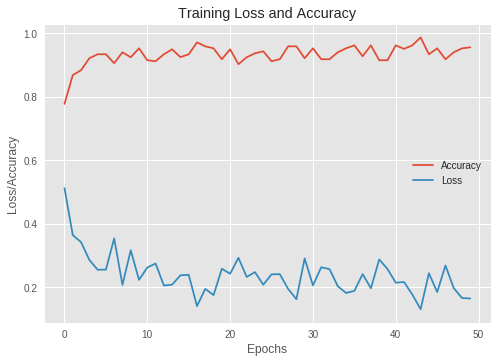

In [77]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [78]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [79]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 27.07%, AUC: 41.66%, Accuracy: 50.94%


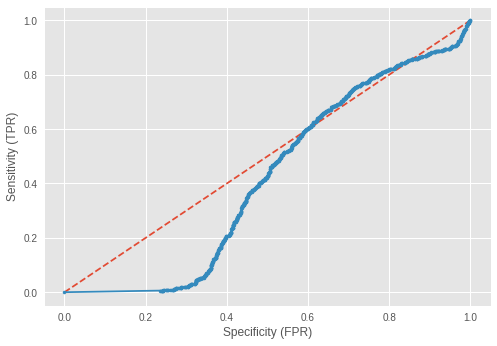

In [80]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 15.88%, AUC: 51.29%, Accuracy: 32.21%

Modelo adaptado do  **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [85]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.4657 - acc: 0.8031 - val_loss: 0.7412 - val_acc: 0.7812

Epoch 00001: val_loss improved from inf to 0.74121, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.3664 - acc: 0.8875 - val_loss: 0.8686 - val_acc: 0.6932

Epoch 00002: val_loss did not improve from 0.74121
Epoch 3/50
 - 1s - loss: 0.2536 - acc: 0.9344 - val_loss: 0.5624 - val_acc: 0.8516

Epoch 00003: val_loss improved from 0.74121 to 0.56240, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 4/50
 - 1s - loss: 0.2091 - acc: 0.9406 - val_loss: 0.6367 - val_acc: 0.8672

Epoch 00004: val_loss did not improve from 0.56240
Epoch 5/50
 - 1s - loss: 0.2108 - acc: 0.9344 - val_loss: 0.3708 - val_acc: 0.8906

Epoch 00005: val_loss improved from 0.56240 to 0.37081, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 6/50
 - 1s - loss: 0.1731 - acc: 0.9500 - val_loss: 0.6219 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

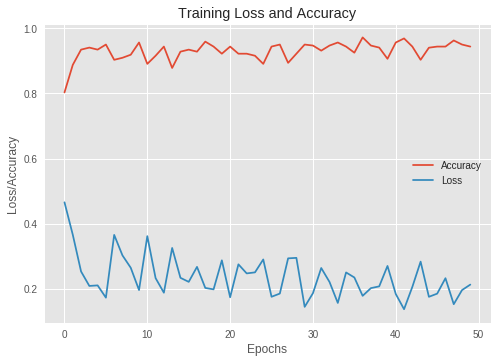

In [87]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [88]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [89]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 15.88%, AUC: 51.29%, Accuracy: 32.21%


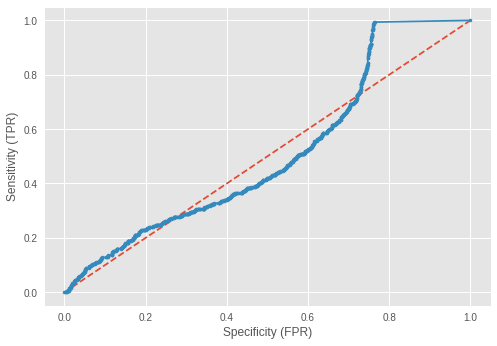

In [90]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa - Test Precision: 19.64%, AUC: 76.44%, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [95]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 3.3770 - acc: 0.5125 - val_loss: 0.4530 - val_acc: 0.8281

Epoch 00001: val_loss improved from inf to 0.45299, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.9132 - acc: 0.6656 - val_loss: 0.5158 - val_acc: 0.8359

Epoch 00002: val_loss did not improve from 0.45299
Epoch 3/50
 - 1s - loss: 1.0061 - acc: 0.8000 - val_loss: 1.5705 - val_acc: 0.7812

Epoch 00003: val_loss did not improve from 0.45299
Epoch 4/50
 - 1s - loss: 0.4355 - acc: 0.8937 - val_loss: 0.8987 - val_acc: 0.8516

Epoch 00004: val_loss did not improve from 0.45299
Epoch 5/50
 - 1s - loss: 0.5177 - acc: 0.8906 - val_loss: 0.6656 - val_acc: 0.9062

Epoch 00005: val_loss did not improve from 0.45299
Epoch 6/50
 - 1s - loss: 0.3720 - acc: 0.9188 - val_loss: 1.0227 - val_acc: 0.8750

Epoch 00006: val_loss did not improve from 0.45299
Epoch 7/50
 - 1s - loss: 0.5406 - acc: 0.9188 - val_loss: 0.5727 - val_acc: 0.8359

Epoch 00007: val_loss did

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

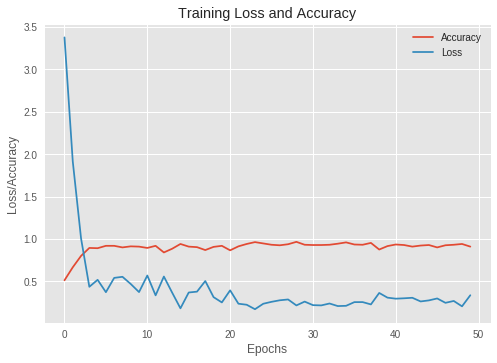

In [97]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [98]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [99]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 76.44%, Accuracy: 19.64%


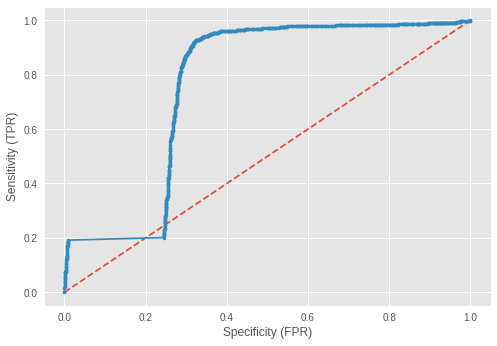

In [100]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 19.64%, AUC: 6.51%, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [105]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 6.3029 - acc: 0.5094 - val_loss: 9.0578 - val_acc: 0.4375

Epoch 00001: val_loss improved from inf to 9.05778, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 2/50
 - 0s - loss: 6.8243 - acc: 0.5312 - val_loss: 7.0428 - val_acc: 0.5000

Epoch 00002: val_loss improved from 9.05778 to 7.04279, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 3/50
 - 0s - loss: 6.4385 - acc: 0.5344 - val_loss: 6.9056 - val_acc: 0.4844

Epoch 00003: val_loss improved from 7.04279 to 6.90559, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 4/50
 - 0s - loss: 5.0783 - acc: 0.5938 - val_loss: 7.6109 - val_acc: 0.5000

Epoch 00004: val_loss did not improve from 6.90559
Epoch 5/50
 - 0s - loss: 2.2654 - acc: 0.7594 - val_loss: 2.2881 - val_acc: 0.8203

Epoch 00005: val_loss improved from 6.90559 to 2.28808, saving model to drive/My Drive/Resultado/Segmentado/weights_architect

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

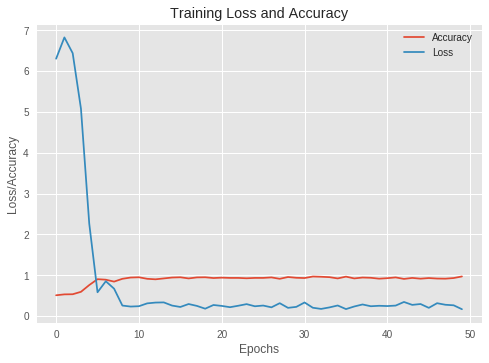

In [107]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [108]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [109]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 6.51%, Accuracy: 19.64%


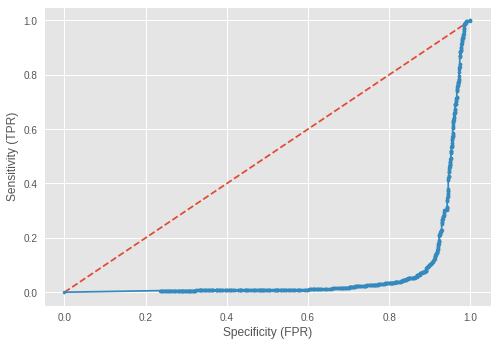

In [110]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 19.64%, AUC: 25.21%, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [115]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.2263 - acc: 0.5719 - val_loss: 0.4955 - val_acc: 0.8125

Epoch 00001: val_loss improved from inf to 0.49550, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.4965 - acc: 0.6469 - val_loss: 0.8468 - val_acc: 0.7578

Epoch 00002: val_loss did not improve from 0.49550
Epoch 3/50
 - 1s - loss: 0.8514 - acc: 0.7438 - val_loss: 0.4892 - val_acc: 0.8906

Epoch 00003: val_loss improved from 0.49550 to 0.48918, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.4285 - acc: 0.8844 - val_loss: 0.5882 - val_acc: 0.8750

Epoch 00004: val_loss did not improve from 0.48918
Epoch 5/50
 - 1s - loss: 0.4382 - acc: 0.9031 - val_loss: 0.3113 - val_acc: 0.9375

Epoch 00005: val_loss improved from 0.48918 to 0.31133, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 6/50
 - 1s - loss: 0.4275 - acc: 0.9062 - val_loss: 0.1572 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

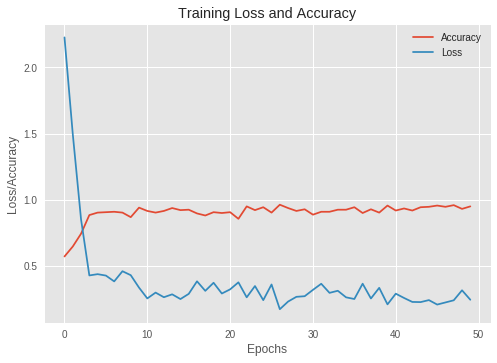

In [117]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [118]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [119]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 25.21%, Accuracy: 19.64%


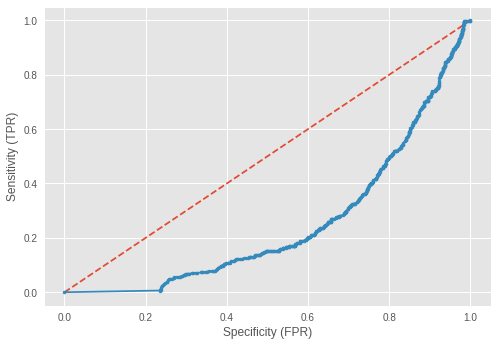

In [120]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 19.64%, AUC: 38.05%, Accuracy: 19.64%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [125]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 3.8162 - acc: 0.5125 - val_loss: 1.6476 - val_acc: 0.5000

Epoch 00001: val_loss improved from inf to 1.64762, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 2.2319 - acc: 0.5625 - val_loss: 0.7354 - val_acc: 0.6641

Epoch 00002: val_loss improved from 1.64762 to 0.73537, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 3/50
 - 0s - loss: 0.8959 - acc: 0.7113 - val_loss: 0.8376 - val_acc: 0.6172

Epoch 00003: val_loss did not improve from 0.73537
Epoch 4/50
 - 1s - loss: 0.9124 - acc: 0.7156 - val_loss: 0.4424 - val_acc: 0.8594

Epoch 00004: val_loss improved from 0.73537 to 0.44237, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 5/50
 - 1s - loss: 0.9302 - acc: 0.7156 - val_loss: 0.7578 - val_acc: 0.7812

Epoch 00005: val_loss did not improve from 0.44237
Epoch 6/50
 - 1s - loss: 0.4134 - acc: 0.8563 - val_loss: 1.0545 - val_

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

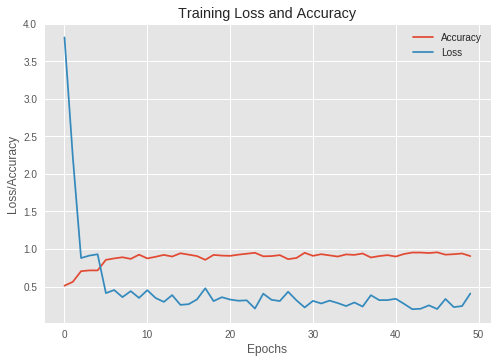

In [127]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [128]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [129]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 38.05%, Accuracy: 19.64%


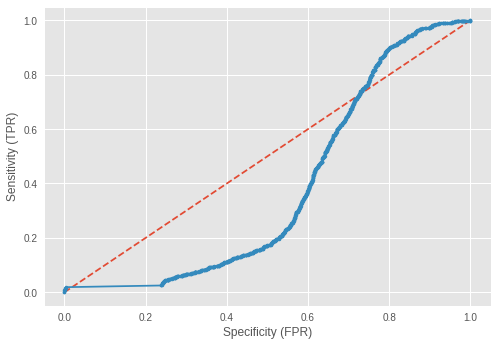

In [130]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 19.64%, AUC: 86.10%, Accuracy: 19.64%

Modelo adaptado do  **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [135]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 2.8241 - acc: 0.4937 - val_loss: 2.2859 - val_acc: 0.4844

Epoch 00001: val_loss improved from inf to 2.28593, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 2.2926 - acc: 0.5406 - val_loss: 0.9409 - val_acc: 0.5391

Epoch 00002: val_loss improved from 2.28593 to 0.94087, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.4690 - acc: 0.5812 - val_loss: 0.3779 - val_acc: 0.8750

Epoch 00003: val_loss improved from 0.94087 to 0.37791, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.5908 - acc: 0.7594 - val_loss: 0.6086 - val_acc: 0.8203

Epoch 00004: val_loss did not improve from 0.37791
Epoch 5/50
 - 1s - loss: 0.5411 - acc: 0.8000 - val_loss: 0.2009 - val_acc: 0.9219

Epoch 00005: val_loss improved from 0.37791 to 0.20087, saving model to drive/My Drive/Resultado/Segmentado/weights_archit

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

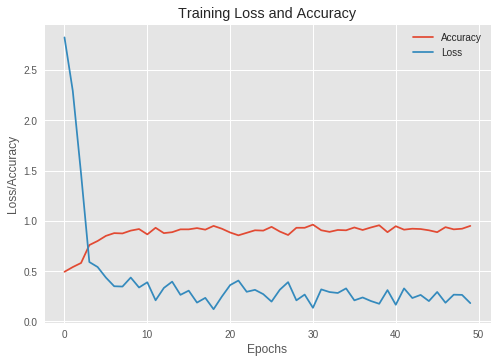

In [137]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [138]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [139]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 86.10%, Accuracy: 19.64%


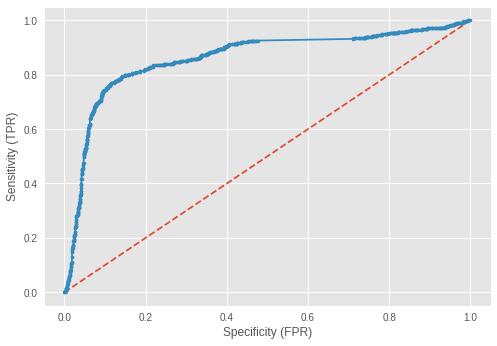

In [140]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 19.64%, AUC: 29.24%, Accuracy: 19.64%

Modelo adaptado do **Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [145]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 6s - loss: 0.8775 - acc: 0.6688 - val_loss: 0.6368 - val_acc: 0.8203

Epoch 00001: val_loss improved from inf to 0.63676, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.5685 - acc: 0.8031 - val_loss: 0.4505 - val_acc: 0.8906

Epoch 00002: val_loss improved from 0.63676 to 0.45046, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.3664 - acc: 0.8563 - val_loss: 0.6591 - val_acc: 0.8438

Epoch 00003: val_loss did not improve from 0.45046
Epoch 4/50
 - 0s - loss: 0.1869 - acc: 0.9531 - val_loss: 0.8184 - val_acc: 0.8182

Epoch 00004: val_loss did not improve from 0.45046
Epoch 5/50
 - 1s - loss: 0.3407 - acc: 0.9281 - val_loss: 0.7295 - val_acc: 0.8594

Epoch 00005: val_loss did not improve from 0.45046
Epoch 6/50
 - 1s - loss: 0.1840 - acc: 0.9656 - val_loss: 0.3280 - val_acc: 0.8828

Epoch 00006: val_loss improved from 0.45046 to 0.32800, saving model to d

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

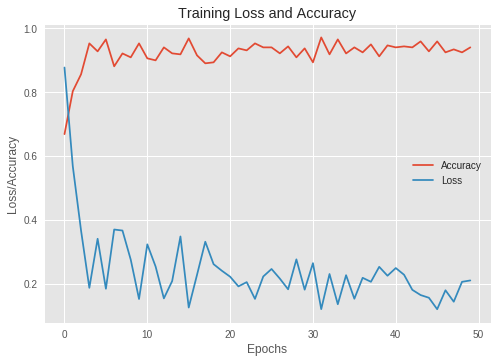

In [147]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [148]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [149]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.2f}%, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              100 * results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 19.64%, AUC: 29.24%, Accuracy: 19.64%


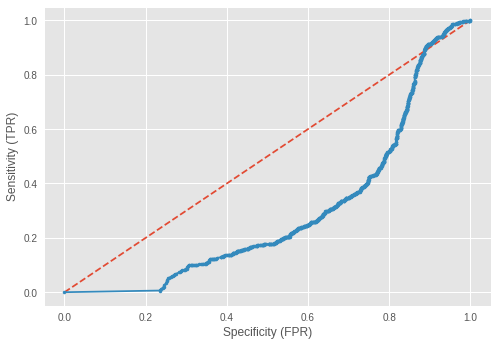

In [150]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('Sensitivity (TPR)')
plt.xlabel('Specificity (FPR)')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')